In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import librosa

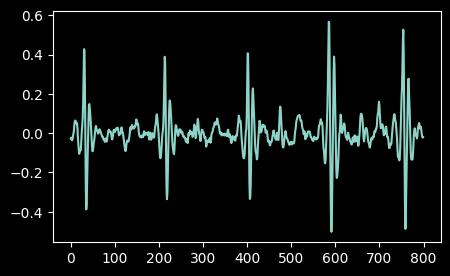

In [3]:
radar_signal = np.load('data_example/radar_signal.npy')
input_radar = radar_signal[:800] # input radar signal
plt.figure(figsize=(5,3))
plt.plot(input_radar)
plt.style.use('default')

### Dynamic Template Matching

[1.0773175090223623, 1.437534972859987, 12.297714830997931, 22.859712327217377] 0.27147818309289007


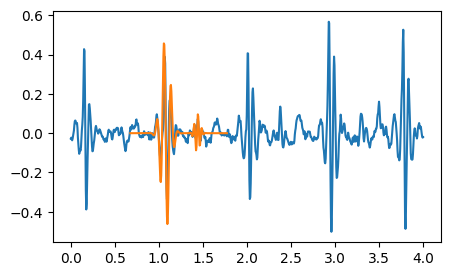

In [4]:
from scipy.optimize import minimize
from scipy.optimize import Bounds

dt = .005
n = 400*2 # length of the synthesic template
fs = 1/dt
t = np.linspace(0,n,n)*dt
a1,a2,mu_1,mu_2,sigma_1,sigma_2, db, f1, f2 = [0.5,0.1,0.4,0.85,0.05,0.03, 0.01, 10, 23]

def loss(params, X, y):
    mu_1,mu_2, f1, f2 = params
    win_start, win_end = int((mu_1-0.3)*fs), int((mu_1+0.7)*fs)
    # Calculate predictions
    xt_1=np.cos(2*np.pi*X*f1)*a1*np.exp(-(X-mu_1)**2/(2*sigma_1**2))
    xt_2=np.cos(2*np.pi*X*f2)*a2*np.exp(-(X-mu_2)**2/(2*sigma_2**2))
    xt=xt_1+xt_2
    y_select = (y[win_start:win_end])
    xt_select = (xt[win_start:win_end])
    # Calculate errors
    MSE = np.sqrt(np.mean((y_select - xt_select) ** 2))
    cor = np.corrcoef(y_select,xt_select)[0,1]
    return MSE+1-cor

# Constraint on the related position of two prominent peaks
def cons1(params):
    return params[1]-params[0]-0.25
constraints = ({'type': 'ineq', 'fun': cons1})


target_sig = input_radar

cost_min = 100
costs = []
# try different initial value to avoid locl minimum
for guess in np.arange(1,3,0.2):
    x0 = [guess, guess+0.3, 10, 23] # initial value to T1, T2, f1 f2
    bounds = Bounds([1,1,8,20], [3,3,15,25])
    res = minimize(loss, x0, method='SLSQP', bounds=bounds, constraints=constraints, args=(t, target_sig), tol=1e-8)
    costs.append(res.fun)
    if res.fun<cost_min:
        mu_1,mu_2,f1, f2 = res.x
        cost_min = res.fun

print([mu_1,mu_2,f1, f2], cost_min)
win_start, win_end = int((mu_1-0.4)*fs), int((mu_1+0.7)*fs)
xt_1=np.cos(2*np.pi*t*f1)*a1*np.exp(-(t-mu_1)**2/(2*sigma_1**2))
xt_2=np.cos(2*np.pi*t*f2)*a2*np.exp(-(t-mu_2)**2/(2*sigma_2**2))
xt=xt_1+xt_2
plt.figure(figsize=(5,3))
plt.plot(t,(target_sig),label='Raw Radar Signal')
plt.plot(t[win_start:win_end],(xt[win_start:win_end]),label='Synthetic Signal')

### Harmonic and Percussive Components Decomposition

In [ ]:
# normalize signal to [0,1]
def norm_sig(sig):
    sig = (sig - np.min(sig)) / (np.max(sig) - np.min(sig))
    return sig

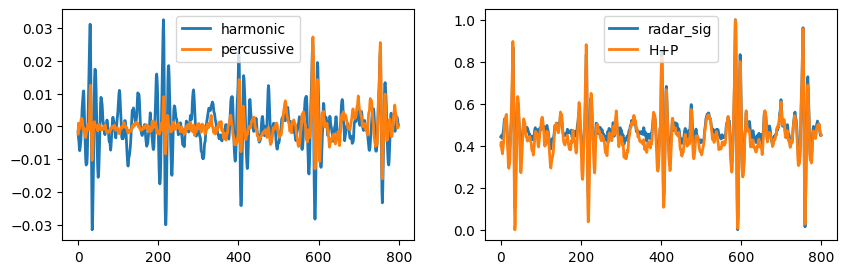

In [5]:
harmonic, percussive = librosa.effects.hpss(input_radar, margin=5, win_length=512, center=True, n_fft=512)
plt.figure(figsize=(10,3))
plt.subplot(1,2,1)
plt.plot((harmonic-np.mean(harmonic)),linewidth=2,label='harmonic')
plt.plot((percussive-np.mean(percussive)),linewidth=2,label='percussive')
plt.legend()
plt.subplot(1,2,2)
plt.plot(norm_sig(input_radar),linewidth=2,label='radar_sig')
plt.plot(norm_sig((harmonic)+(percussive)),linewidth=2,label='H+P')
plt.legend()
plt.show()

### Spectrogram Generation

In [6]:
def HP_Aug(sst_h, sst_p, start_t, start_f, aug_arg = 100): 
    cover_length, cover_width = 12//2, 6//2
    start_f = sst_h.shape[1]-start_f
    start_t = int(start_t/fs*30) # the frequency for the spectrogram is 30
    for i in range(sst_h.shape[0]):
        sst_h[i][:,start_t-cover_length:start_t+cover_length] = 0
        sst_h[i][start_f-cover_width:start_f+cover_width,:] = 0
    return sst_h+sst_p

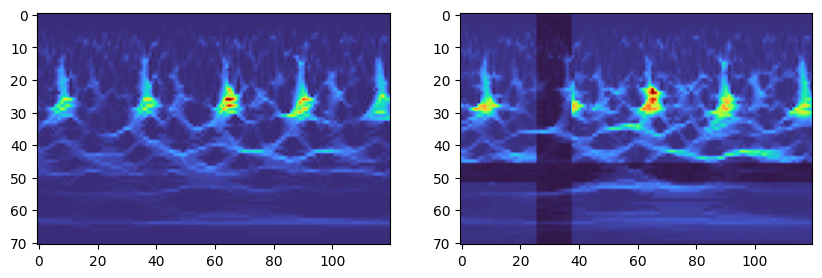

In [7]:
# Numerous methods can be used to generate spectrogram, e.g., STFT, CWT, SST
# Here we directly load the spectrogram
spec_org = np.load('data_example/sst_seg_42_org.npy')
spec_harmonic = np.load('data_example/sst_seg_42_h.npy')
spec_percussion = np.load('data_example/sst_seg_42_p.npy')
start_t, start_f = int(mu_1*fs), int(f2)
spec_HP = HP_Aug(spec_harmonic, spec_percussion, start_t, start_f)
plt.figure(figsize=(10, 3))
plt.subplot(1,2,1)
plt.imshow(spec_org[1,:,:], aspect='auto',  cmap='turbo', label="org")
plt.subplot(1,2,2)
plt.imshow(spec_HP[1,:,:], aspect='auto',  cmap='turbo', label="HP Aug")